# TD Régression

## Régression linéaire pour la détection précoce d'épidémies via les données de requête sur un moteur de recherche

Les épidémies de [grippe](https://fr.wikipedia.org/wiki/Grippe) ([influenza](https://en.wikipedia.org/wiki/Influenza)) constituent un problème de santé publique majeur, avec problèmes respiratoires, fièvre, hospitalisations, décès...
Les *Centers for Disease Control and Prevention* (CDC) américains et le  *European Influenza Surveillance Scheme* (EISS) détectent l'activité de la grippe via un réseau de surveillance virologique et clinique, dont le nombre *Influenza-like Illness* `ILI` de visites liées à la grippe chez le médecin. 
Le problème considéré ici est la détection précoce de l'épidémie via l'examen des [requêtes sur un moteur de recherche](https://www.google.org/flutrends/) liées aux symptomes et à l'information sur la maladie. 



 Le problème va ici être traité avec des données américaines, mais les données européennes et françaises sont disponibles très facilement ([ici](http://ecdc.europa.eu/en/data-tools/Pages/home.aspx) et [là](https://www.google.org/flutrends/fr/#FR)). 

- ILI Data - The CDC publishes on its website the official regional and state-level percentage of patient visits to healthcare providers for ILI purposes on a weekly basis.

- Google Search Queries - Google Trends allows public retrieval of weekly counts for every query searched by users around the world. For each location, the counts are normalized by dividing the count for each query in a particular week by the total number of online search queries submitted in that location during the week. Then, the values are adjusted to be between 0 and 1.

Le fichier csv `FluTrain.csv` aggrège les données ILI et les requêtes Google entre le 1er janvier 2004 et le 31 décembre 2011. Le fichier comporte alors les colonnes suivantes :

- "Week" - The range of dates represented by this observation, in year/month/day format.

- "ILI" - This column lists the percentage of ILI-related physician visits for the corresponding week.

- "Queries" - This column lists the fraction of queries that are ILI-related for the corresponding week, adjusted to be between 0 and 1 (higher values correspond to more ILI-related search queries).

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn.linear_model
%matplotlib inline

### Question 1 : récupération des données - premières observations

**À faire :** A l'aide du module **`pandas`**, chargez le fichier csv `FluTrain.csv`, sous le nom `fluTrain`, en utilisant la méthode pd.read_csv. 

In [2]:
df = pd.read_csv('FluTrain.csv')
df.head()

,Week,ILI,Queries
0,2004-01-04 - 2004-01-10,2.418331,0.237716
1,2004-01-11 - 2004-01-17,1.809056,0.220452
2,2004-01-18 - 2004-01-24,1.712024,0.225764
3,2004-01-25 - 2004-01-31,1.542495,0.237716
4,2004-02-01 - 2004-02-07,1.437868,0.224436


Avant d'appliquer quelque méthode que ce soit, on va s'intéresser un peu aux données elles-même.

**À faire :** Affichez les 10 premieres lignes des données.

**Conseil :** Souvenez vous que [`df.loc[]`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html#pandas.DataFrame.loc) permet d'adresser les lignes d'un dataframe df, et que pour accéder à un élément, il faut faire [`df[colonne][ligne]`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [33]:
print(df[0:100])

                       Week       ILI   Queries   log_ILI  unnormalized_query
0   2004-01-04 - 2004-01-10  2.418331  0.237716  0.883078            1.664011
1   2004-01-11 - 2004-01-17  1.809056  0.220452  0.592805            1.543161
2   2004-01-18 - 2004-01-24  1.712024  0.225764  0.537676            1.580345
3   2004-01-25 - 2004-01-31  1.542495  0.237716  0.433401            1.664011
4   2004-02-01 - 2004-02-07  1.437868  0.224436  0.363162            1.571049
..                      ...       ...       ...       ...                 ...
95  2005-10-30 - 2005-11-05  1.254889  0.300133  0.227047            2.100930
96  2005-11-06 - 2005-11-12  1.336609  0.227092  0.290136            1.589641
97  2005-11-13 - 2005-11-19  1.378636  0.322709  0.321095            2.258964
98  2005-11-20 - 2005-11-26  1.608290  0.289509  0.475171            2.026560
99  2005-11-27 - 2005-12-03  1.483106  0.314741  0.394138            2.203187

[100 rows x 5 columns]


**À faire :** Affichez la description par respectivement `fluTrain.describe()`.

In [4]:
df.describe()

,ILI,Queries
count,417.000000,417.000000
mean,1.676861,0.286028
std,1.126163,0.157697
min,0.534093,0.041169
25%,0.902459,0.156707
50%,1.252563,0.281541
75%,2.058690,0.378486
max,7.618892,1.000000


En considérant la période de 2004 à 2011 (exclu),

**À faire :** Tracez sur le même graphique l'évolution des indices ILI et Queries au cours des semaines.

**Conseil :** Regardez la documentation de [`matplotlib.pyplot.plot`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) et pensez à normaliser les valeurs de la colonne ILI pour que la valeur maximum soit égale à 1 lors de l'affichage.

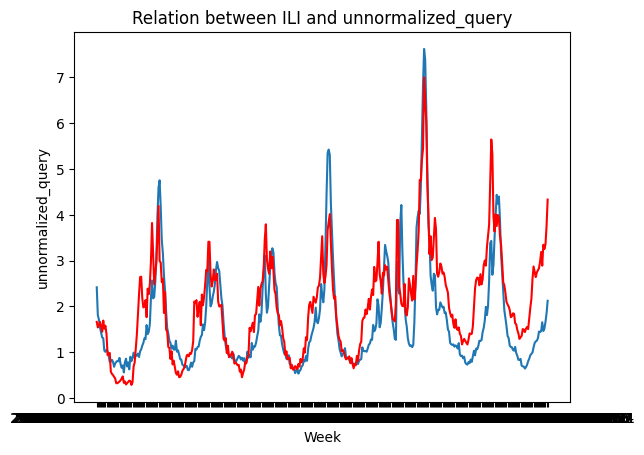

In [32]:
df["unnormalized_query"] = 7 * df["Queries"]

plt.plot(df["Week"],df["ILI"])
plt.plot(df["Week"],df["unnormalized_query"],color='red')
plt.xlabel("Week")
plt.ylabel("unnormalized_query")
plt.title("Relation between ILI and unnormalized_query")
plt.show()


**Questions :**
- Que constatez-vous ? 
- Observez-vous un motif périodique ?
   - oui periodique tout les mois
- Observez-vous que l'une des courbes semble évoluée en avances par rapport à 
plus il y a de recheche plus il y a de malades 
- À partir de ces observations,
   - la relation entre certaine querie et d'autre maladie ou la similariter 
   - Pensez-vous que prendre uniquement la valeur courante de `Queries` pour prédire l’`ILI` est suffisant ?

**Vos réponses :**


ICI


### Question 2 : examen de la variable ILI, nuage de points Queries-ILI

Considérons maintenant les données plus globalement. 

**À faire :** Tracez un histogramme de la variable explicative ILI.

**Conseil :** Regardez la documentation de [`matplotlib.pyplot.hist()`](https://matplotlib.org/gallery/statistics/hist.html).

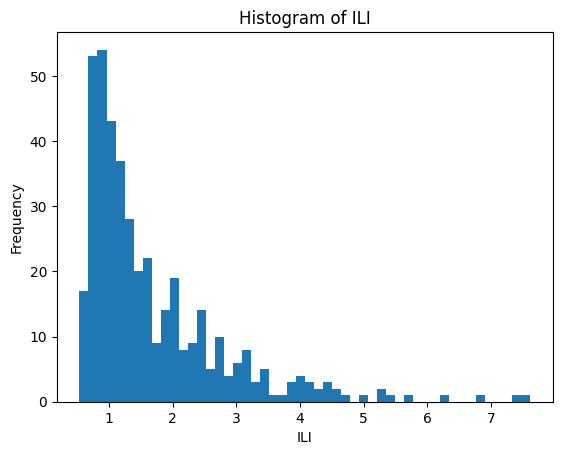

In [24]:
plt.hist(df["ILI"],bins=50)
plt.xlabel("ILI")
plt.ylabel("Frequency")
plt.title("Histogram of ILI")
plt.show()

**Questions :**
- La distribution est-elle asymétrique, symétrique ? 
- Présente-t-elle des événements rares (la queue de la distribution est relativement "élevée" comparativement à une exponentielle ou gaussienne) ?

**Vos réponses :**





**À faire :** Tracer le nuage de points avec la variable Queries en abscisses et la variable ILI en ordonnée.

**Conseil :** Regardez la documentation de [`matplotlib.pyplot.scatter()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter).

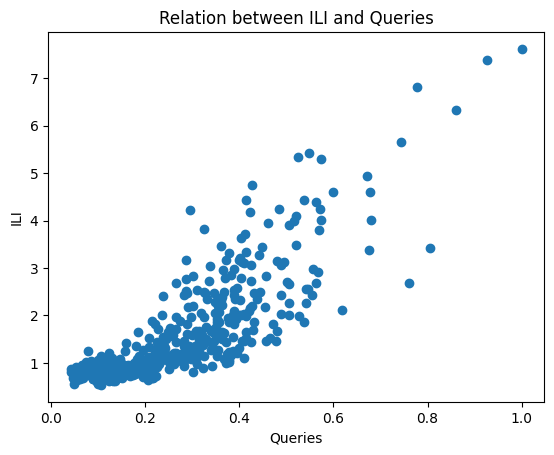

In [21]:
plt.scatter(df["Queries"],df["ILI"])
plt.xlabel("Queries")
plt.ylabel("ILI")
plt.title("Relation between ILI and Queries")
plt.show()

**Questions :** Ce nuage indique t-il un lien linéaire entre les 2 variables disponibles ?

**Vos réponses :**





### Question 3 Nuage de points Queries - log(ILI)

**À faire :** Ajoutez à `fluTrain` une colonne `'log_ILI'` qui contient le logarithme de la colonne `'ILI'`

**Conseil :** Regardez la documentation de [`pandas.DataFrame.apply()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) et de [`numpy.log()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html).

In [23]:
df['log_ILI']=np.log(df['ILI'])

**À faire** : Tracer le nuage de points du logarithme de ILI en fonction de la variable Queries.

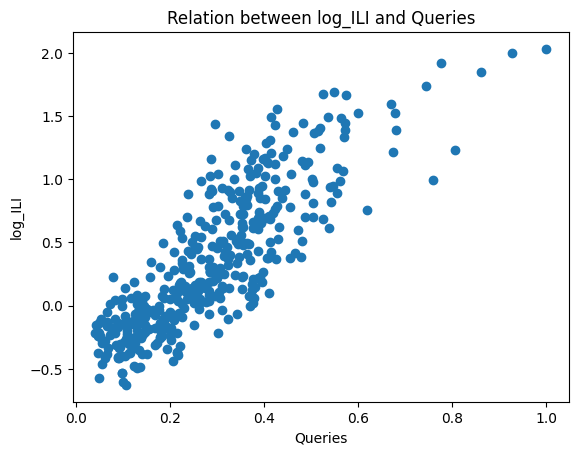

In [22]:
plt.scatter(df["Queries"],df["log_ILI"])
plt.xlabel("Queries")
plt.ylabel("log_ILI")
plt.title("Relation between log_ILI and Queries")
plt.show()

**Questions :** 
- Qu'est-ce que ce tracé suggère ?
- oui relation positive entre log_ILI et Queries

**Vos réponses :**





**À faire** : Calculez la corrélation entre ces deux variables.

**Conseil :** Regardez la documentation de [`numpy.corrcoef()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html)

In [37]:
np.corrcoef(df["Queries"],df["log_ILI"])
print("Correlation coefficient between Queries and log_ILI:",np.corrcoef(df["Queries"],df["log_ILI"])[0,1])

Correlation coefficient between Queries and log_ILI: 0.8420332863659171


### Question 4 : Régression linéaire de log(ILI) par rapport à Queries (prédire le nb de visites en fct du nb de requêtes sur internet.

**À faire** : Effectuer une régression linéaire entre log(ILI) et Queries.

**Conseil :** Regardez la documentation de [`sklearn.linear_model.LinearRegression()`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [40]:
regr=sklearn.linear_model.LinearRegression()
regr.fit(df[['Queries']], df['log_ILI'])

LinearRegression()

**Questions :** Quels sont les coefficients obtenus ?

In [42]:
regr.coef_

array([2.96129248])

**Questions :** 
- Quel est le score R2 ?
- La prédiction est elle efficace (explique t-elle la variance de la variable logILI ?)

In [44]:
regr.score(df[['Queries']], df['log_ILI'])

0.7090200553481865

**Vos réponses :**





**À faire** : Tracer le nuage de points et la droite de régresssion. 

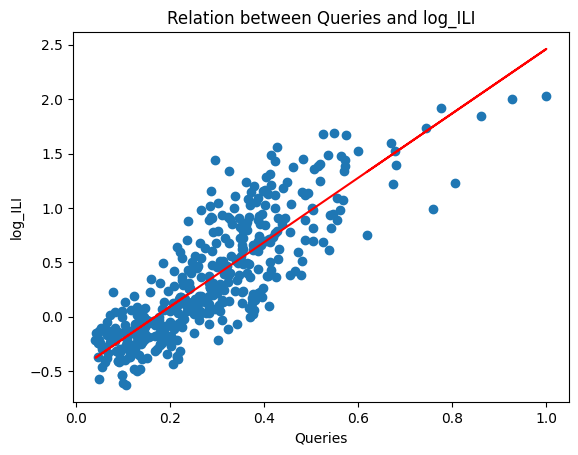

In [45]:
plt.scatter(df["Queries"],df["log_ILI"])
plt.plot(df["Queries"],regr.predict(df[['Queries']]),color='red')
plt.xlabel("Queries")
plt.ylabel("log_ILI")
plt.title("Relation between Queries and log_ILI")
plt.show()

**Questions :** Quel est l'accroissement moyen du nombre de visites pour un accroissement de 10 % des requêtes sur internet liées à la grippe?

**Vos réponses :**





### Question 5: Performances de cette régression sur une base de test (les données de l' année suivante) 

Le fichier csv `FluTest.csv` contient les données pour l'année 2012. 

**À faire :** 
- Chargez ces données dans un dataframe `fluTest`.
- Ajoutez à `fluTest` une colonne `'log_ILI'` qui contient le logarithme de la colonne `'ILI'`
- Calculez l'ensemble des prédictions de ILI pour la variable `Queries` de la base de test.

**Conseil :**  Prenez garde au fait que le modèle vous permet de prédire le **log** de ILI, et vous devez donc au passage prendre quelque part une exponentielle.

In [47]:
flutest= pd.read_csv("FluTest.csv")
flutest["log_ILI"]=np.log(flutest["ILI"])
flutest["predicted_log_ILI"]=regr.predict(flutest[['Queries']])

**À faire :** Tracer le nuage de points et la courbe de régresssion.

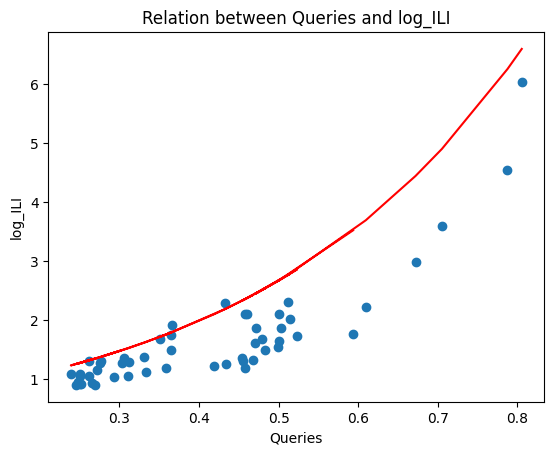

In [51]:
plt.scatter(flutest["Queries"],flutest["ILI"])
flutest["predicted_ILI"]=np.exp(regr.predict(flutest[['Queries']]))
plt.plot(flutest["Queries"],np.exp(flutest["predicted_log_ILI"]),color='red')
plt.xlabel("Queries")
plt.ylabel("log_ILI")
plt.title("Relation between Queries and log_ILI")
plt.show()

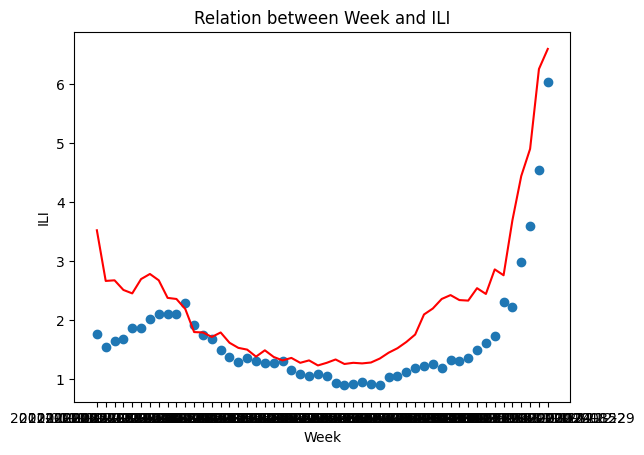

In [52]:
plt.plot(flutest["Week"],flutest["predicted_ILI"],color='red')
plt.scatter(flutest["Week"],flutest["ILI"])
plt.xlabel("Week")
plt.ylabel("ILI")
plt.title("Relation between Week and ILI")
plt.show()

**Questions :** 
- Quelle est votre estimée pour le nombre de visites chez le médecin liées à la grippe, pour la semaine du 11 mars 2012 ?
- Quelle était la vraie valeur de ce nombre ?

**Questions :** Quels sont les RSS et RSE sur la base de test?

In [55]:
rss=np.sum((flutest["predicted_ILI"]-flutest["ILI"])**2)
print("RSS = %.2f"%(rss, ))
RSE=np.sqrt(rss/(len(flutest)-2))
print("RSE = %.2f"%(RSE, ))

RSS = 29.18
RSE = 0.76


### Question 6 : Régression linéaire multiple

Pour améliorer le modèle, on pourra chercher à prévoir logILI, le logarithme du nombre de visites chez le médecin, non seulement en fonction des Queries courantes mais aussi des Queries des semaines précédentes et des enregistrements du nombre de visites les semaines précédentes. Du fait des délais de transmission, on ne dispose en général pas des nombres de visites la semaine précédente mais seulement de celles avec un retard de 2 semaines et au-delà.

**À faire :** Ajoutez à `fluTrain` et `fluTest` les colonnes `'log_ILI2'` et `'log_ILI3'` qui correspondent aux nombres de visites les 2e et 3e semaines précédentes, ainsi que les colonnes `'Queries1'`, `'Queries2'` pour les deux semaines précédentes.

**Conseil :** Regardez la documentation de [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html)

**À faire :** Tracer les nuages de points pour déterminer les variables à priori liées à logILI que l'on veut prédire

**À faire : **Calculez la matrice d'cocorrélation et faire le lien avec les observations précédentes.

In [ ]:
def correlation_matrix(df):

    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Cocorrélation')
    labels=['',]+list(df.columns)
    ax1.set_xticklabels(labels,fontsize=10)
    ax1.set_yticklabels(labels,fontsize=10)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix(fluTrain[features+['log_ILI']])

**À faire :** Mettre en oeuvre une régression qui permette de prédire `log_ILI` en fonction du `Queries` actuelle et des variables explicatives des semaines passées.

**À faire :** Donner les RSS et RSE sur la base de test, commentez.

## Régression par plus proches voisins

Nous allons mettre en oeuvre la technique des plus proches voisins pour essayer de prédire le nombre de visites à partir des variables explicatives vues précédemment  nombre de requêtes 

### Question 7 : PPV  avec une seule variable explicative

**À faire :** Reprendre la fonction reg_knn_1D du cours pour tester les performances de cette régression. (Vous pourrez modifier les valeurs du nombre de PPV testées).


In [ ]:
from sklearn import neighbors

def reg_knn_1D(x_train, y_train, x_test, y_test, k):
    plt.figure(figsize=(8, 8))
    knn = neighbors.KNeighborsRegressor(k, weights='uniform')
    knn.fit(x_train, y_train)
    yppv=knn.predict(x_test)
    S=knn.score(x_test, y_test)
    plt.scatter(x_train, y_train, c='r')
    plt.scatter(x_test,y_test, c='b')
    idx = x_test[x_test.columns[0]].argsort()
    plt.plot(x_test[x_test.columns[0]][idx], yppv[idx], c='g',linewidth=2, label=('PPV K=%d, score= %.2f'%(k,S)))
    plt.legend(fontsize=15)

### Question 8 : PPV avec toutes les variables explicatives

**À faire :** Reprendre les variables utilisées pour la régression linéaire multiple et tester la régression par la méthode des k-PPV (Vous pourrez modifier les valeurs du nombre de PPV testées).

### Question 9 : Choix automatique du nombre de voisins

Nous voulons effectuer la recherche du nombre de voisins optimal (qui obtient la meilleure performance) de manière automatique. Pour cela, nous allons simplement tester un grand nombre de valeur pour k (par exemple entre 1 et 50) et choisir la valeur de k qui obtient la  meilleure performance. Mais la question qu’il se pose est sûr quel ensembles devons-nous effectuer la mesure de performance ?

En effet, si nous choisissons la valeur de k qui obtient la meilleure performance sur l’ensemble d’entrainement, il y a de très fortes chances que cette valeur de k entraine un sur-apprentissage (appris par cœur) de l’ensemble d’entrainement.
Et si nous choisissons la valeur de k qui obtient la meilleure performance sur l’ensemble de test, nous ne pouvons plus garantir que notre apprentissage offre une bonne généralisation.

Il nous faut alors un 3eme ensemble pour tester la performance de notre algorithme de régression en fonction du paramètre k. cette ensemble s’appelle l’ensemble de **validation** et il est obtenu en découpant d’ensemble d’entrainement.

**À faire :** Découpez l'ensemble d'entraimenent `fluTrain` en deux ensemble `fluTrain2` et `fluVal`.

**Conseil :** Regardez la documentation de [`sklearn.model_selection.train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [ ]:
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

**À faire :** Testez pour des valeurs de k entre 1 et 50 la performance obtenue avec le score RSE sur l'ensemble de `fluVal` (avec l'apprentissage sur `fluTrain2`).

**Questions : **
- Pour quelle valeur de k, le RSE est-il minimum ?
- Si vous utilisez cette valeur de k dans la question précédente, avez-vous une meilleure performance que la régression linéaire ?

**Vos réponses :**




    